<a href="https://colab.research.google.com/github/ujs/open_data/blob/master/Facebook_Metrics_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Problem Definition**

The dataset I analyse is related to posts' published during the year of 2014 on the Facebook page of a renowned cosmetics brand. It contains performance metrics on posts made to the page. It has 19 attributes/features- these include 7 features known prior to post publication and 12 features for evaluating post impact (hence this problem has multiple output features). The data is used to analyse relationships between input and output features, and train a couple of models to predict post performance based on input features.


### **Importing Libraries and Loading Data**

In [1]:
#Importing the necessary visualisation adn data analysis libraries
import pandas as pd
import numpy as np
import math
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import fancyimpute
import missingno as mn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
import pydotplus
from scipy.cluster import hierarchy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Unzipping and Loading data
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip' -d /content
!unzip Facebook_metrics.zip 
dataset_Facebook = 'dataset_Facebook.csv'

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'Facebook_metrics.zip' (UTF-8) -> 'Facebook_metrics.zip' (UTF-8)
--2020-06-05 16:52:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Caching archive.ics.uci.edu => 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
Created socket 5.
Releasing 0x0000558c11712a80 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 5 to SSL handle 0x0000558c11736000
certificate:
  subject: CN=*.ics.uci.edu,OU=Donald Bren School of Information and Computer Sciences,O=University of California\\, Irvine,street=501 Aldrich Hall,L=Irvine,ST=California,postalCode=92697,C=US
  issuer:  CN=InCommon RSA Server CA,OU=InCommon,O=Internet2,L=Ann Arbor,ST=MI,C=US
X509 certificate successful

### **Initial Data Exploration**

In [3]:
original_data = pd.read_csv(dataset_Facebook, delimiter = ';')
original_data.head()


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [4]:
# Looking at the data types of columns (except 'Type', all features are numeric)
original_data.dtypes

# Note- 'Page total likes' refers to how many likes the page had when post went live

Page total likes                                                         int64
Type                                                                    object
Category                                                                 int64
Post Month                                                               int64
Post Weekday                                                             int64
Post Hour                                                                int64
Paid                                                                   float64
Lifetime Post Total Reach                                                int64
Lifetime Post Total Impressions                                          int64
Lifetime Engaged Users                                                   int64
Lifetime Post Consumers                                                  int64
Lifetime Post Consumptions                                               int64
Lifetime Post Impressions by people who have liked y

In [5]:
original_data.shape

(500, 19)

In [6]:
#Investigating missing values (very few missing values)
original_data.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

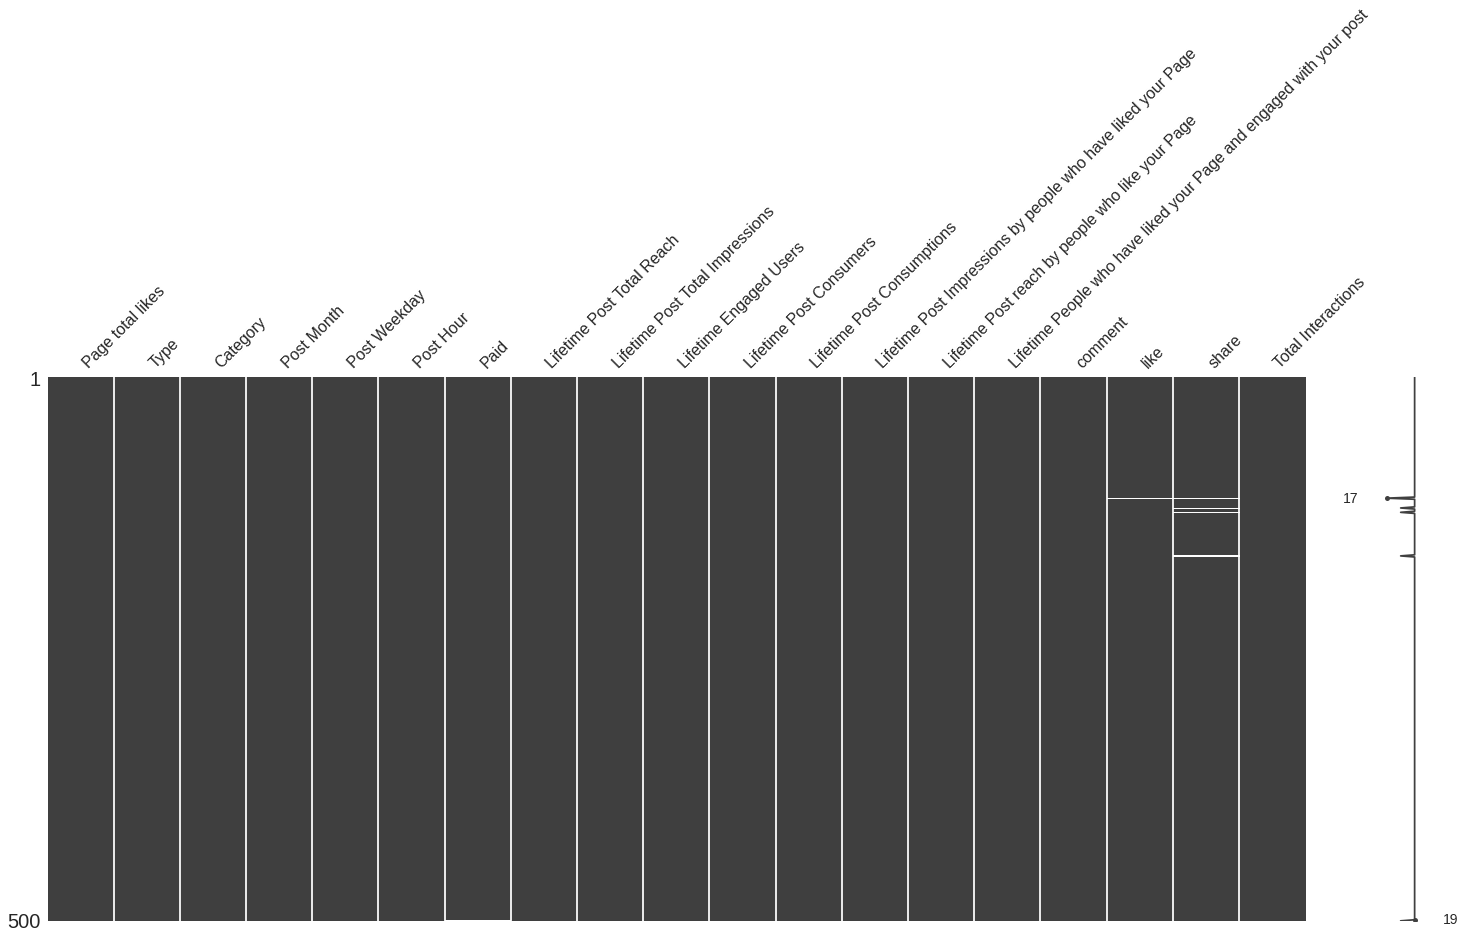

In [7]:
mn.matrix(original_data)

In [8]:
original_data.Type.value_counts(dropna = False) #Most posts are photos

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

### **Data Cleaning and Visualization**

In [9]:
#Function that inputs original dataframe and outputs cleaned dataframe
def clean_df(original_data):
  df = original_data.copy()
  df.dropna(subset = ['Paid'], inplace = True)
  df.fillna(0, inplace = True)
  return df

df = clean_df(original_data)
df.isna().sum().sum()

0

In [10]:
df.Paid.value_counts()

0.0    360
1.0    139
Name: Paid, dtype: int64

In [11]:
df.Category.value_counts()

1    215
3    155
2    129
Name: Category, dtype: int64

In [12]:
df['Post Weekday'].value_counts()

7    82
6    81
4    71
1    68
5    67
2    66
3    64
Name: Post Weekday, dtype: int64

In [13]:
df['Post Month'].value_counts()

10    60
7     52
12    50
4     50
6     49
11    45
5     37
9     36
3     36
8     34
2     26
1     24
Name: Post Month, dtype: int64

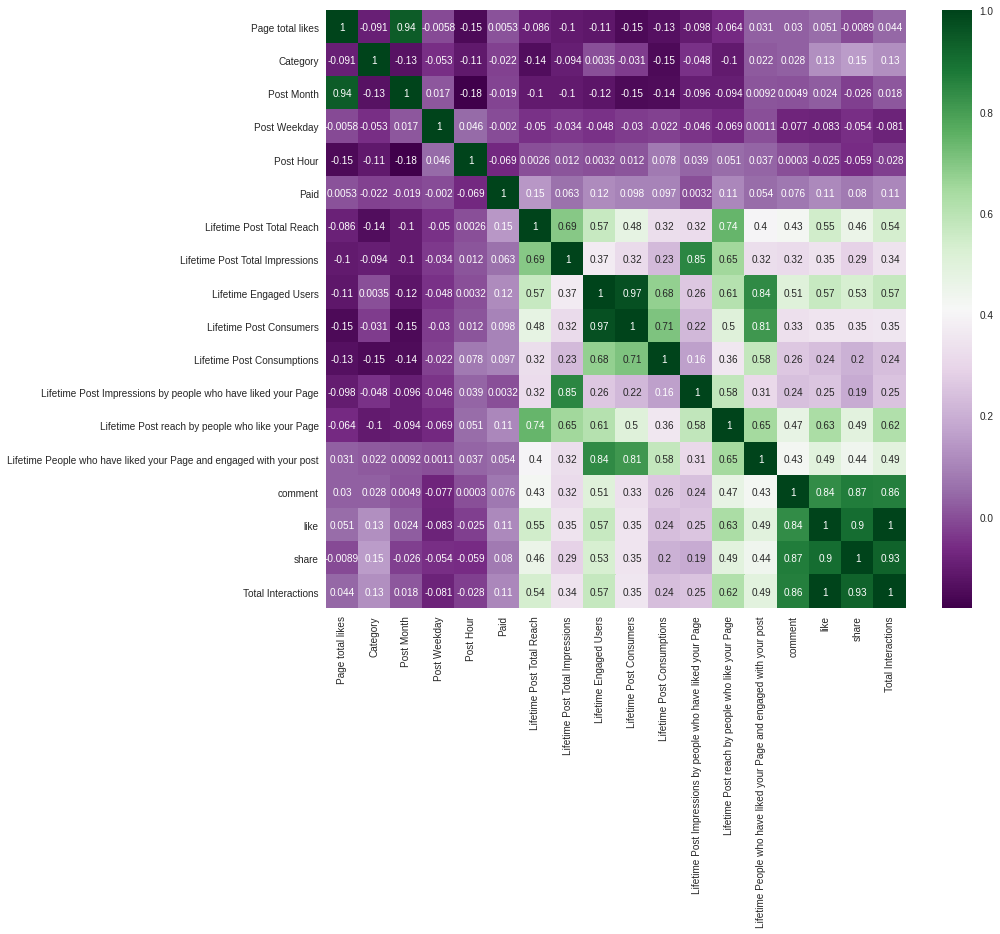

In [14]:
#Correlation Matrix
plt.figure(figsize=(13,11))
sns.heatmap(df.corr(),cmap='PRGn' ,annot=True)

Since, only the first seven features are input variables and the rest are output variables, we extract all the input variables and 2 output variables into a new dataframe.

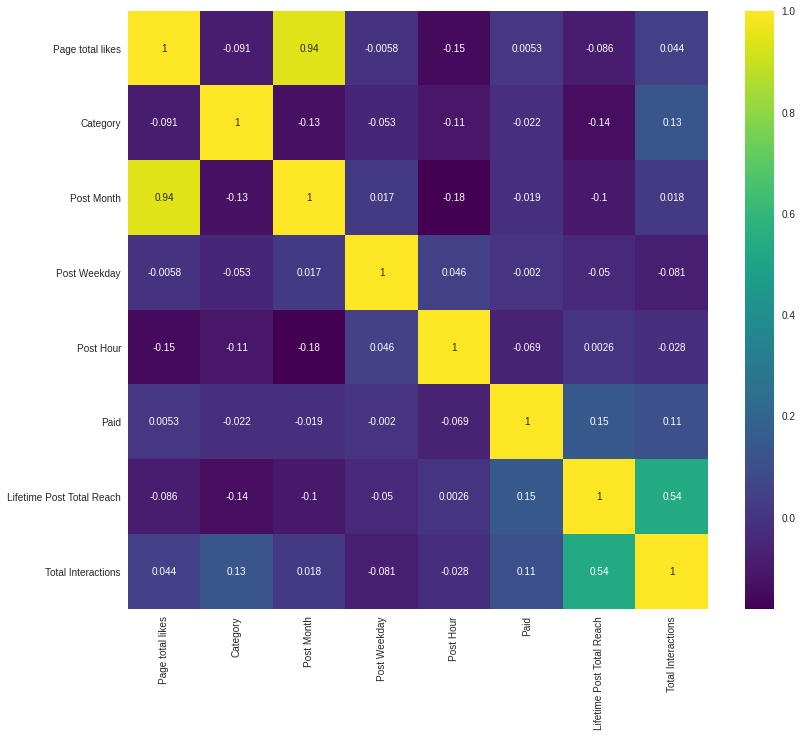

In [16]:
#Zoom into only input variables and a couple of output variables. I chose 'Lifetime Total Reach' and 'Total Interactions'
modified_df = df.drop(df.columns[8:-1], axis = 1)
plt.figure(figsize=(13,11))
sns.heatmap(modified_df.corr(),cmap='viridis' ,annot=True)

Note that 'Page total likes' and 'Post Month' have a correlation of 0.94 but this does not give any useful information because page total likes means the number of likes the page has at the time of the post and as time progresses, the likes monotonically increase (if the cosmetic company undergoes a public relations fiasco and people start unliking their page, then things would be different but ignore that for now).

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


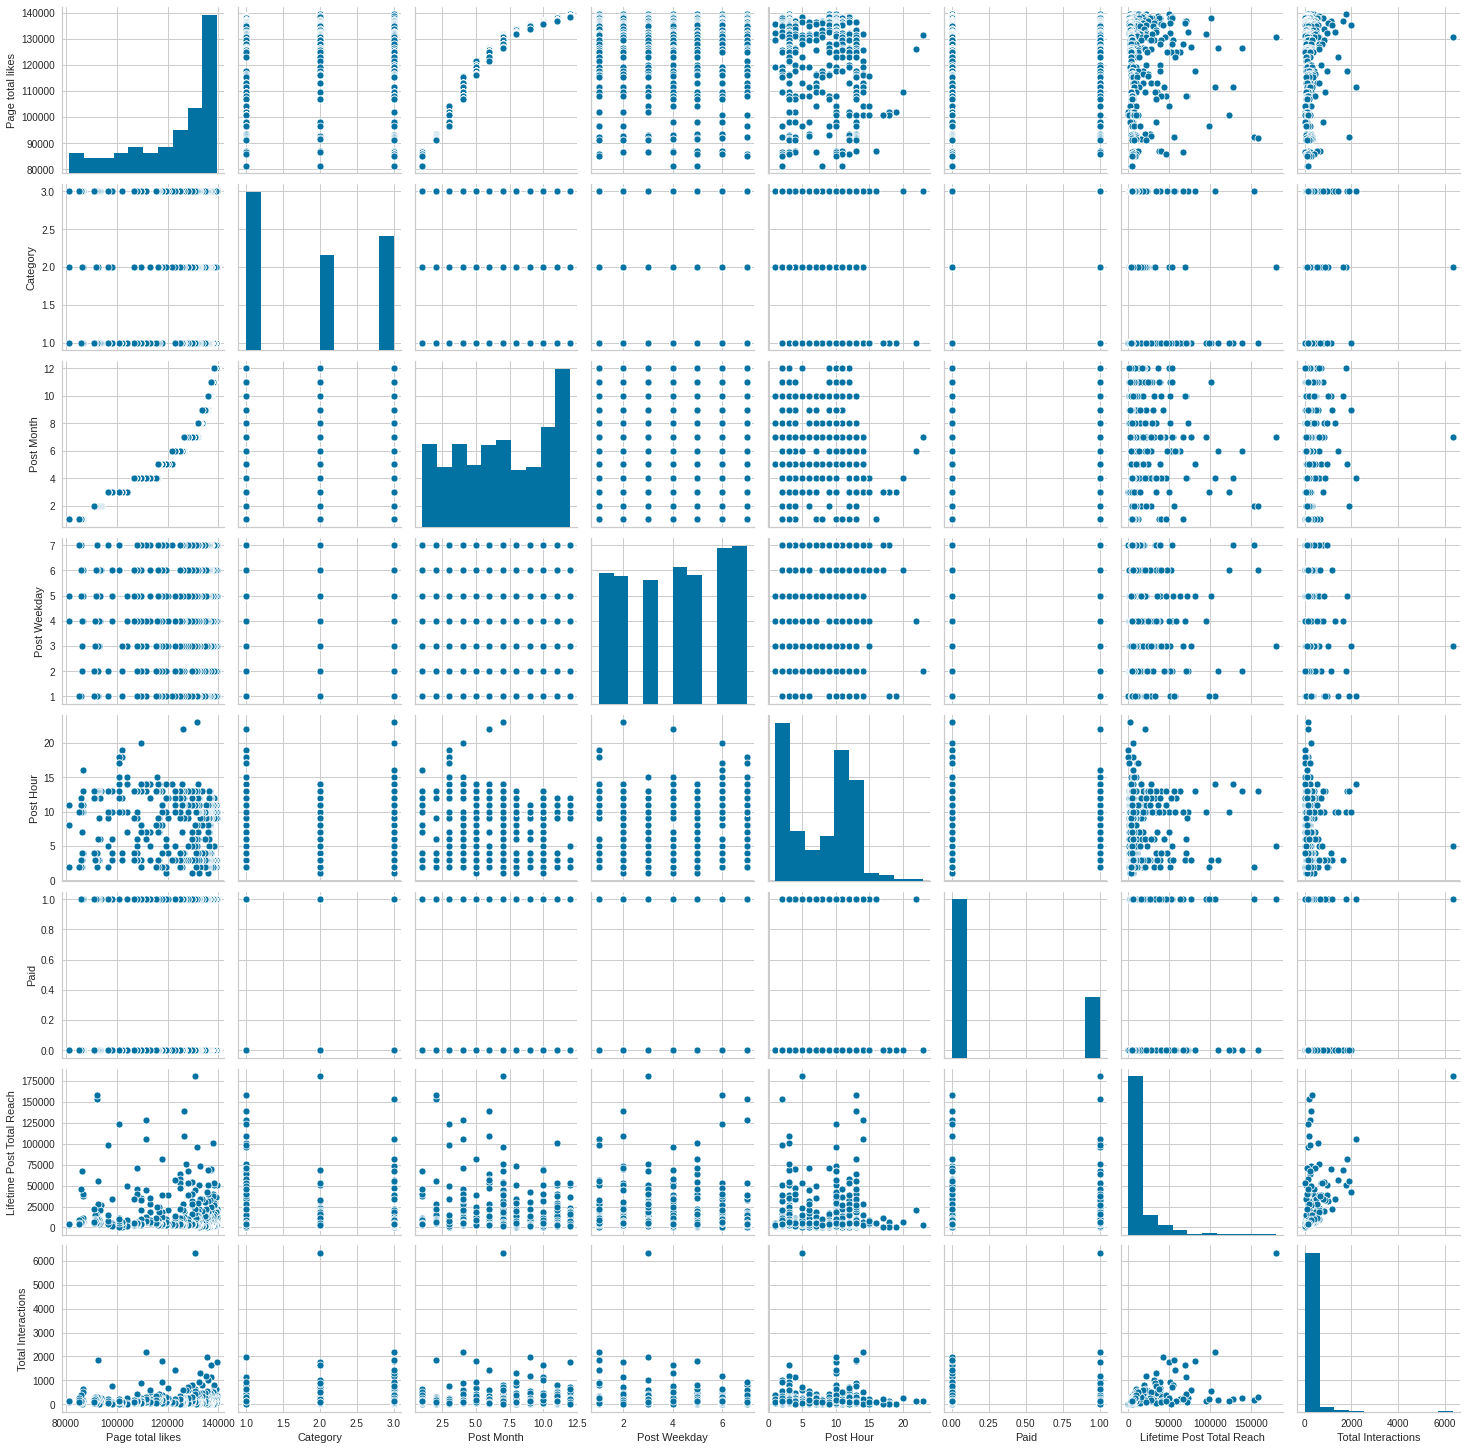

In [17]:
#Pair plots and histograms for input features and two output features
sns.pairplot(data = modified_df, size=2.5)

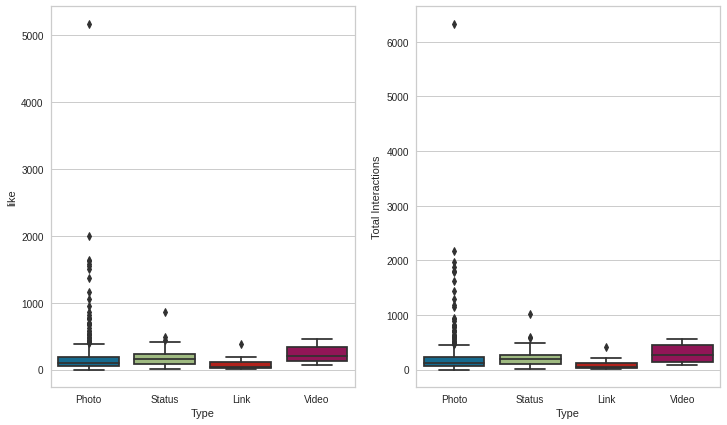

In [18]:
fig,axes = plt.subplots(1,2, figsize =(12,7) )

#Distribution of likes per post by type
sns.boxplot(x=df['Type'],y=df['like'], ax = axes[0])

#Distribution of total interactions per post by type
sns.boxplot(x=df['Type'],y=df['Total Interactions'], ax = axes[1])

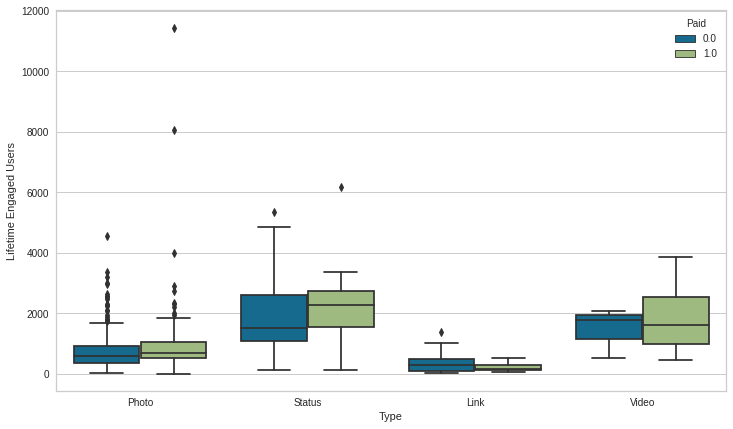

In [19]:
#Distribution of Lifetime Engaged Users/post by Type and if post was paid or non-paid
plt.figure(figsize=(12,7))
sns.boxplot(x=df['Type'],y=df['Lifetime Engaged Users'], hue = df.Paid)

Paid posts do slightly better especially in terms of outliers. Some paid posts like photos end up getting lot more user traction. Paid status updates surprisinlgy have the highest median for 'Lifetime Engaged Users'. I was expecting paid photos and videos to do better.

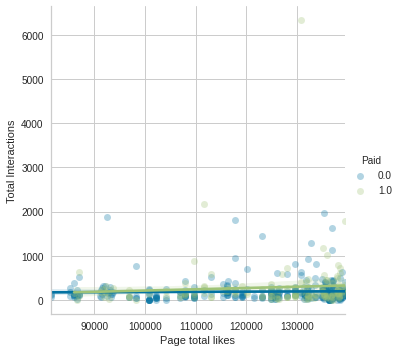

In [20]:
sns.lmplot(x='Page total likes', y='Total Interactions', data=df, x_jitter=1, scatter_kws={'alpha':.3},
           hue='Paid')

There is a very week indication from the plot above that paid posts had more user engagement but this observation is not very conclusive.

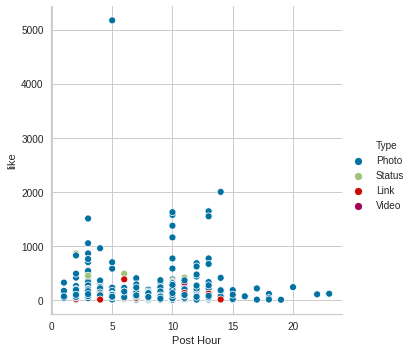

In [21]:
sns.relplot(x='Post Hour', y='like', data=df, hue='Type')

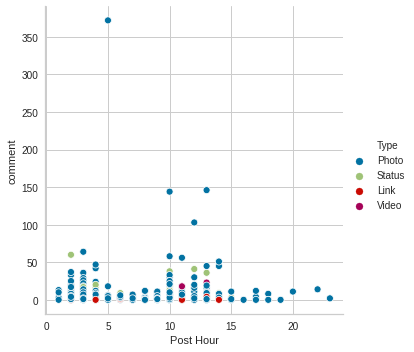

In [22]:
sns.relplot(x='Post Hour', y='comment', data=df, hue='Type')

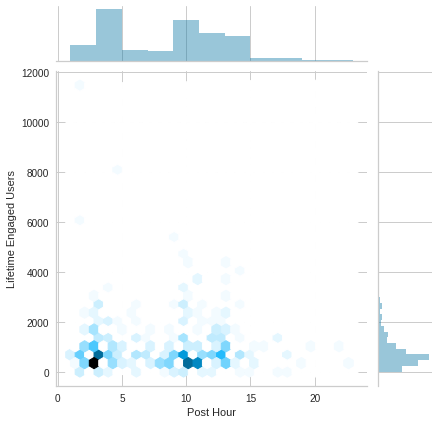

In [26]:
# combine frequency and scatter plot
sns.jointplot(x='Post Hour', y='Lifetime Engaged Users', data=df, kind='hex' )

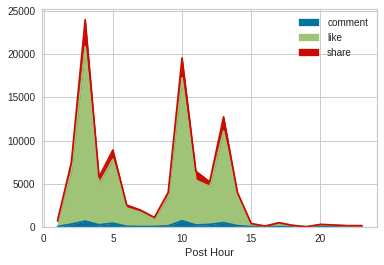

In [30]:
#Area plot to visualize type and number of posts made hourly
df_area = pd.pivot_table(data = df, values = ['like','share','comment'], index = 'Post Hour', aggfunc = 'sum')
df_area.plot.area()


From the plots above it appears that more posts are made during the following hours: 1AM to 4AM (peak sleeping hours) and 10AM  to 2PM (peak working hours) and these posts tend to have higher user engagement as well which is very counterintuitive.

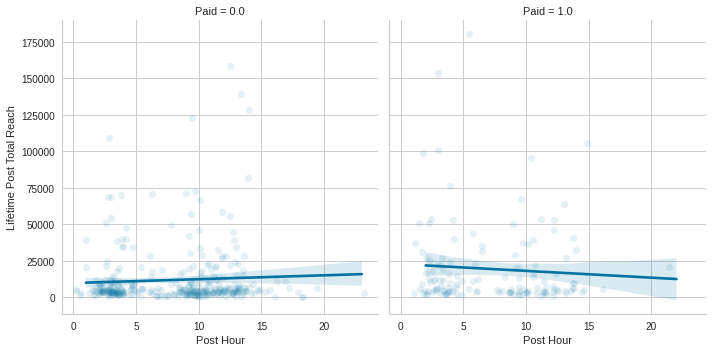

In [25]:
sns.lmplot(x='Post Hour', y='Lifetime Post Total Reach', data=df, x_jitter=1, scatter_kws={'alpha':.1},
          col='Paid', col_wrap=2)

In [27]:

pd.pivot_table(df, values='Lifetime Engaged Users', index='Type', aggfunc='mean')


,Lifetime Engaged Users
Type,
Link,342.818182
Photo,819.545882
Status,2040.222222
Video,1707.000000


In [28]:
pd.pivot_table(df, values='Lifetime Engaged Users', index='Paid', aggfunc='mean')

,Lifetime Engaged Users
Paid,
0.0,849.447222
1.0,1106.525180


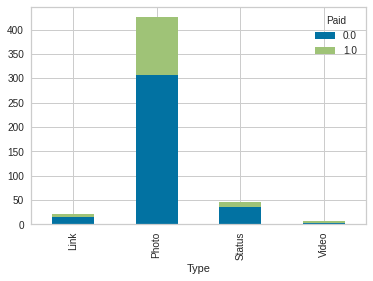

In [29]:
#Distribution of Type of Posts (stacked based on paid or non-paid)
(df
 .pipe(lambda df2: pd.crosstab(df2.Type, df2.Paid))
 .plot.bar(stacked=True)
)

In [30]:
df.groupby('Paid')['Lifetime Post Total Reach'].describe()

,count,mean,std,min,25%,50%,75%,max
Paid,,,,,,,,
0.0,360.0,11851.216667,20039.868487,238.0,3108.0,4903.0,10256.0,158208.0
1.0,139.0,19288.158273,28006.286388,813.0,3751.0,7132.0,22544.0,180480.0


In [31]:
sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

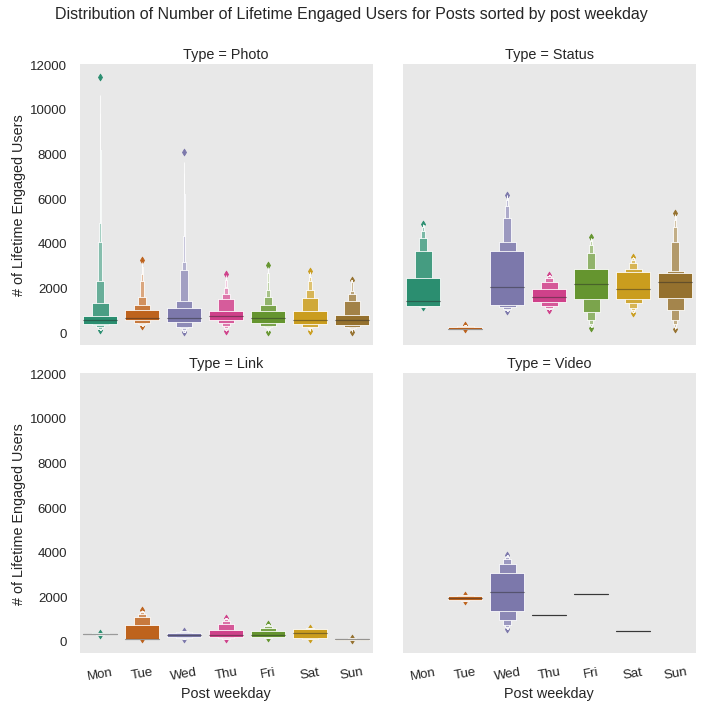

In [32]:
# Accent color palette
with sns.color_palette('Dark2'):
  with sns.plotting_context('paper', font_scale = 1.5):
    with sns.axes_style('dark', {'axes.facecolor':'E8E8E8'}):
      g = sns.catplot(x='Post Weekday', y= 'Lifetime Engaged Users',
                  data=df, kind='boxen', col='Type', col_wrap=2)
      
plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
g.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 10)
g.set_axis_labels("Post weekday","# of Lifetime Engaged Users")
g.fig.suptitle('Distribution of Number of Lifetime Engaged Users for Posts sorted by post weekday', fontsize = 16,)
g.fig.subplots_adjust(top=.9)

             
            

In [33]:
pd.pivot_table(df, values = 'Lifetime Engaged Users', 
               index = 'Type', columns ='Post Weekday', aggfunc = 'sum')

Post Weekday,1,2,3,4,5,6,7
Type,,,,,,,
Link,626.0,1524.0,545.0,1634.0,1430.0,1641.0,142.0
Photo,59037.0,47177.0,50277.0,51856.0,39488.0,51707.0,48765.0
Status,8799.0,569.0,20844.0,6756.0,18511.0,16425.0,19906.0
Video,NaN,3859.0,4389.0,1141.0,2101.0,459.0,NaN


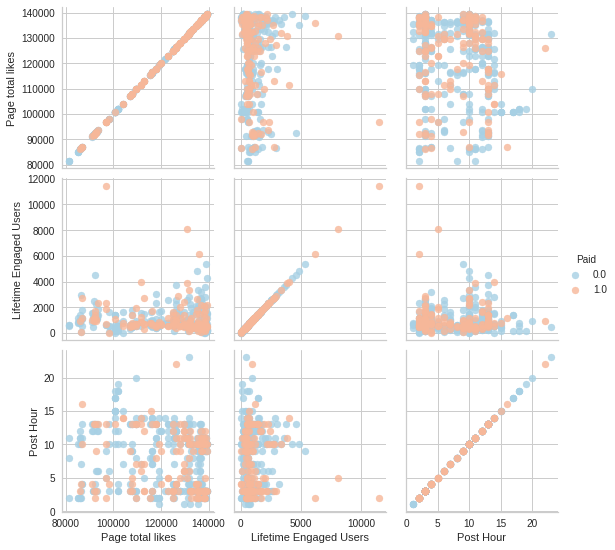

In [34]:
g = sns.PairGrid(df, vars=['Page total likes','Lifetime Engaged Users','Post Hour'],
                 hue='Paid', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

Paid posts seem to have higher user engagement especially, if we look at outlier points in maxima region in the plots above.

### **Supervised Machine Learning**

I will use a simple linear regression model and random forests to predict the number of 'Lifetime Engaged Users' for a post based on the input variables. Before I proceed, I have to transform the data by normalizing it. In addition there are some extreme outlier posts with very high engagement- so, I will clip them at the 97th percentile.

In [0]:
def data_transform(df):
  #Clip Outliers
  outlier_clip = np.percentile(df['Lifetime Engaged Users'], 97)
  df = df[df['Lifetime Engaged Users']< outlier_clip]

  #Standardise data
  X = df.iloc[:,:7]
  X = pd.get_dummies(X)
  Y = df['Lifetime Engaged Users']
  feature_cols = X[X.columns]
  std = preprocessing.StandardScaler()
  X_std = pd.DataFrame(std.fit_transform(feature_cols), columns=feature_cols.columns)

  #Split data into train and test set
  X_train,X_test,Y_train, Y_test = train_test_split(X_std, Y, test_size = 0.1, random_state = 1)

  return X_train,X_test,Y_train, Y_test

X_train,X_test,Y_train, Y_test = data_transform(df)


In [36]:
#Initializing the models and fit the models to the data
regression_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100)

#Fitting models to the data

regression_model.fit(X_train,Y_train)
rf_model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

R squared is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. This is a common performance metric used to evaluate models solving regression problems. Hence, I use this metric.

In [37]:
#Evaluating performance of the 2 models

#Regression Prediction
predicted_train_regression  = regression_model.predict(X_train)
predicted_test_regression  = regression_model.predict(X_test)

#Random Forests Prediction
predicted_train_rf = rf_model.predict(X_train)
predicted_test_rf = rf_model.predict(X_test)

#We will use R-squared as metric to evaluate performance of the models

#Regression r2 score
reg_r2_train = r2_score(y_pred=predicted_train_regression,y_true=Y_train)
reg_r2_test = r2_score(y_pred=predicted_test_regression,y_true=Y_test)

#Random Forest r2 score
rf_r2_train = r2_score(y_pred=predicted_train_rf,y_true=Y_train)
rf_r2_test = r2_score(y_pred=predicted_test_rf,y_true=Y_test)

print ("R squared for training data(regression) is: ", reg_r2_train )
print ("R squared for test data(regression) is: ", reg_r2_test )
print ("R squared for training data(random forests) is: ", rf_r2_train )
print ("R squared for test data(random forests) is: ", rf_r2_test )

R squared for training data(regression) is:  0.2898976750522242
R squared for test data(regression) is:  0.12093798272018874
R squared for training data(random forests) is:  0.8897635633292502
R squared for test data(random forests) is:  0.2270349618060611


Random forests do much better than the regression model on the trainig set but both models generalize poorly on the test set.

### **Unsupervised Machine Learning**

In [38]:
X = pd.get_dummies(df)
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)

#Principal Component Analysis
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
0,-1.802935,0.272500,1.840264,0.491828,-0.507613,0.474221,0.364037,-0.011550,-0.391967,0.809438,0.040008,0.100195,0.119552,-0.031625,0.014080,0.128094,-0.046313,0.323653,0.031400,0.000752,-2.226304e-15,4.800884e-16
1,0.828291,-3.650331,1.502592,-0.313531,-0.002287,1.280479,-0.519185,0.947174,0.165761,-0.976887,-0.017902,-0.630888,0.846573,-0.014656,-0.373374,0.325975,-0.092641,0.275998,0.010942,-0.007202,-1.564662e-15,-3.080232e-17
2,-1.899491,0.372725,1.853288,0.108280,-0.516658,1.043099,0.982079,0.407961,-0.073313,0.598544,-0.435003,0.575016,0.163363,0.078791,0.057632,0.127550,-0.072000,0.367200,0.043114,-0.002391,-4.824392e-16,2.153941e-16
3,6.779144,2.911413,3.503878,0.521863,0.258339,-0.567654,-0.070343,0.108525,-0.041283,-1.840421,-0.527229,-0.466925,-1.321151,0.836040,-0.657036,0.447426,0.302963,0.491201,-0.239811,-0.088224,8.677544e-16,-1.006446e-15
4,-0.257413,0.701982,2.307841,0.120427,-0.298230,0.359113,0.597623,0.737046,-0.827509,0.580717,0.223597,0.085777,0.121431,-0.165760,-0.071441,0.001536,0.012582,0.333419,0.021457,-0.005261,4.116296e-16,-8.941499e-17


In [39]:
pca.explained_variance_ratio_

array([3.05414753e-01, 1.18170936e-01, 1.03651862e-01, 8.24922190e-02,
       6.46973464e-02, 5.49590547e-02, 4.94761477e-02, 4.52375755e-02,
       4.29393419e-02, 3.71209352e-02, 2.57380905e-02, 2.39750513e-02,
       1.57241479e-02, 1.34699918e-02, 6.33367096e-03, 4.35920903e-03,
       3.24582737e-03, 2.37072805e-03, 5.99985367e-04, 2.31269599e-05,
       7.29561483e-33, 1.10925669e-33])

First 3 principal components explain >50% of the variance. Hence, I will visualize those components below. Most of the features explaining maximum variability in the first 3 components are features that are recorded AFTER the post is published. The main prior features (features recorded BEFORE post published) I see in the components are 'Type', 'Page Total Likes', 'Category' and 'Post Month'.

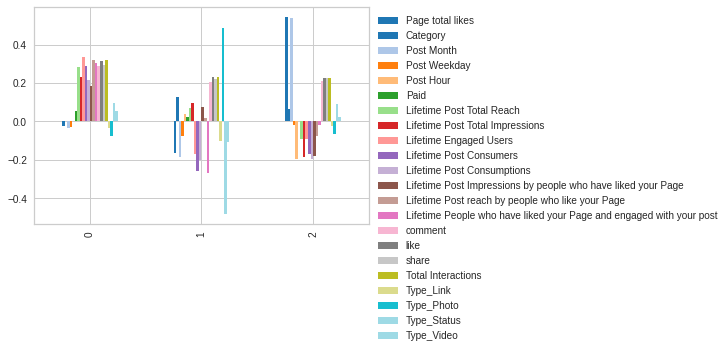

In [40]:
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[:3]
 .plot.bar(cmap = 'tab20')
 .legend(bbox_to_anchor=(1,1)))

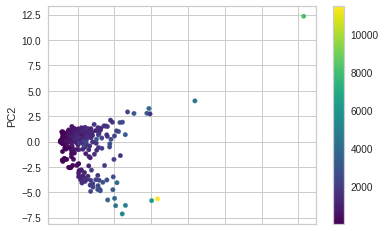

In [68]:
pca_X.plot.scatter(x='PC1', y='PC2', c = X['Lifetime Engaged Users'], cmap = 'viridis')

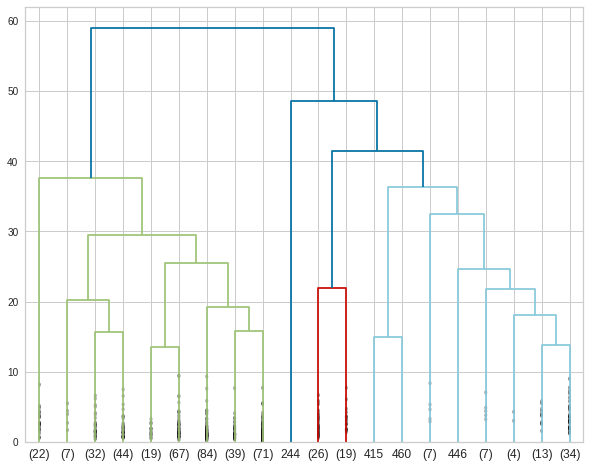

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),truncate_mode='lastp', p=20, show_contracted=True)

pass

I initially do hierarchical clustering using 3 clusters because we can see three clusters at depth level 1 in the dendrogram.

In [44]:
agg = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
agg.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

One out of the 3 clusters contains only posts that are photos. This cluster also had higher engagement and reach numbers. Then I go one level higher in the dendrogram and see 2 clusters. So I do hierarchical clustering with 2 clusters. I see that all the videos and status posts are only in one cluster- the cluster with all status posts has much higher engagement numbers than the other cluster.

In [45]:
X.assign(label = agg.labels_).groupby('label').agg(['mean', 'std', 'min', 'max'])

Page total likes                        ... Type_Video        
                  mean           std     min  ...        std min max
label                                         ...                   
0        126931.787611  12734.987225   86909  ...   0.242133   0   1
1        122186.064935  16940.186348   81370  ...   0.000000   0   0
2        130791.000000           NaN  130791  ...        NaN   0   0

[3 rows x 88 columns]

In [41]:
agg = cluster.AgglomerativeClustering(n_clusters =2, affinity = 'euclidean', linkage = 'ward')
agg.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [42]:
X.assign(label = agg.labels_).groupby('label').agg(['mean', 'std', 'min', 'max'])

Page total likes                       ... Type_Video        
                  mean           std    min  ...        std min max
label                                        ...                   
0        126965.640351  12683.663673  86909  ...   0.241129   0   1
1        122186.064935  16940.186348  81370  ...   0.000000   0   0

[2 rows x 88 columns]

### **Summary**
My main findings in this study were that photo and status posts received better traction among users. Paid photo/status posts also did better than non-paid photo/status posts. Video posts did not garner as much user attention as I was expecting. Post hours that received maximum traction were made in the afternoon or after midnight which was slightly strange. 
In terms of machine learning, random forests' model did better than the regression model on the training set.